In [3]:
! pip install pandas
! pip install numpy
! pip install statsmodels
! pip install patsy
! pip install statsmodels
! pip install sklearn
! pip install matplotlib

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
from datetime import timedelta
import copy
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import math
from sklearn.linear_model import ElasticNet

%matplotlib inline

In [3]:
# ======================================= #
#                FUNCTIONS                #
# ======================================= #

# convert a timestamp in string format beginning with 'PT' and convert it into corresponding time length in seconds
# DataFrame --> timedelta
def strptimedelta(x):
    t = parse(x.duration.lstrip('PT')).time()
    return timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).seconds

# convert strings into datetime objects
# DataFrame --> datetime
get_debut = lambda x: datetime.strptime(x.debut, '%Y-%m-%dT%H:%M:%SZ').date()
get_time = lambda x: datetime.strptime(x.date, '%Y-%m-%dT%H:%M:%SZ').time()
get_date = lambda x: datetime.strptime(x.date, '%Y-%m-%dT%H:%M:%SZ').date()

In [3]:
# return relative proportionate distribution of video categories
# list --> dict
def get_categories(cat_list, categories):
    # initialize dictionary values to 0(zero) with category numbers as keys
    cat_distr = dict.fromkeys(categories, 0)
    
    # count absolute number of videos per category
    for category in cat_list:
        if category in cat_distr.keys():
            cat_distr[category] += 1
    
    # calculate relative proportion of each category
    for category in cat_distr:
        cat_distr[category] = cat_distr[category] / len(cat_list)
    else:
        return cat_distr

In [4]:
# return relative proportionate distribution of video upload time slots
# list --> dict
def get_upload_times(time_list, time_slots):
    # initialize dictionary values to 0(zero) with beginning of time slots as keys
    up_times = dict.fromkeys(time_slots, 0)

    # count absolute number of videos uploaded per time slot
    for time in time_list:
        i = 0
        while i < 23:
            if time_slots[i] <= time < time_slots[i + 1]:
                up_times[time_slots[i]] += 1
                break
            else:
                i += 1
    
    # calculate relative proportion of each time slot
    for time in up_times:
        up_times[time] = up_times[time] / len(time_list)
    else:
        return up_times

In [5]:
# return relative proportion of given dummy variable
# list, str --> float
def get_dummy_prop(item_list, keyword):
    cnt = 0
    for item in item_list:
        if item == keyword:
            cnt += 1
    return cnt / len(item_list)

In [6]:
# return DataFrame containing non-normalized data (1 row = 1 vtuber channel)
# DataFrame, DataFrame, DataFrame, DataFrame, int --> DataFrame
def create_matrix(vtubers, videos, sub_records, view_records, observation_period):
    # list of existing video categories within dataset
    categories = np.sort(videos['category'].unique())
    
    # separate targets
    targets = vtubers[['channel_id', 'total_subs']]
    targets.columns = ['channel_id', 'target']

    # possible time slots (hourly basis) for uploading videos (00:00 ~ 23:00)
    time_slots = []
    time2str = dict()
    times = pd.date_range('2020-06-02', '2020-06-03', freq = 'H')[:-1]
    for time in times:
        time_slots.append(time.time())
        time2str[time.time()] = str(time.time())
    
    # retrieve list of column names for attributes to extract
    columns = ['after_activation', 'vid_cnt', 'avg_duration', 'three_dim', 'definition']
    columns.extend(categories)
    columns.extend(time_slots)
    
    # initialize matrix
    raw_x = {key:[] for key in columns}
    has_agency = []

    for vtuber in vtubers.itertuples():
        # 1. Extract relevant data
        # check for matching channel ID
        all_uploads = videos.loc[videos.channel_id == vtuber.channel_id].sort_values(by = 'date').reset_index(drop = True)
        first_upload = all_uploads.date[0]

        # separate list of videos uploaded within given time period after debut
        all_uploads = all_uploads.loc[all_uploads.date < first_upload + timedelta(observation_period)]

        # 2. Record values for each key
        # record dummy variable for whether vtuber has a managing agency
        if vtuber.agency == ' ':
            has_agency.append(0)
        else:
            has_agency.append(1)
        
        # record no. of days after first video has been uploaded
        raw_x['after_activation'].append(int((datetime(2020,5,26).date() - first_upload).days))
        
        # record number of videos
        raw_x['vid_cnt'].append(len(all_uploads))

        # record average video duration
        avg_duration = all_uploads['duration'].mean()
        raw_x['avg_duration'].append(avg_duration)

        # record proportion of 3d videos
        three_dim = get_dummy_prop(all_uploads['2d3d'], '3d')
        raw_x['three_dim'].append(three_dim)

        # record proportion of hd videos
        hd_prop = get_dummy_prop(all_uploads['definition'], 'hd')
        raw_x['definition'].append(hd_prop)

        # record proportion of each video category
        cat_distr = get_categories(all_uploads['category'], categories)
        for category in categories:
            raw_x[category].append(cat_distr[category])

        # record proportion of each video upload time based on hourly time slots
        up_times = get_upload_times(all_uploads['time'], time_slots)
        for time in time_slots:
            raw_x[time].append(up_times[time])
    
    matrix = pd.DataFrame(raw_x)
    matrix.rename(columns = time2str, inplace = True)
    matrix = pd.concat([vtubers.channel_id, matrix], axis = 1)

    # add dummy variable as column
    matrix['has_agency'] = has_agency

    # merge data matrices & add target
    matrix = pd.merge(pd.merge(pd.merge(matrix, sub_records, on = 'channel_id'), view_records, on = 'channel_id'), 
                      targets, on = 'channel_id')
        
    return matrix

In [7]:
# normalize measured independent variables
# DataFrame, list --> DataFrame
def normalize(matrix, categorical_vars):
    # copy of original matrix
    m_copy = matrix.copy()
    
    # exclude channel_id and target columns
    x_vars = list(m_copy.columns)[1:-1]
    x = m_copy[x_vars]
    
    # normalize independent variables which are not categorical variables
    columns = x.columns
    must_norm = []
    
    for column in x.columns:
        if column not in categorical_vars:
            must_norm.append(column)
    else:
        norm = x[must_norm]
        norm = StandardScaler().fit_transform(norm)
        m_copy[must_norm] = norm
        return m_copy

In [8]:
# draw graph of accumulated explained variance by principal components (assume we can reduce matrix to less than twenty components)
# DataFrame, int --> None
def test_pca(norm_matrix, n_components = 20):
    # exclude channel_id and target columns
    matrix = norm_matrix.copy().iloc[:, 1:-1]
    
    # run a trial PCA
    pca = PCA(n_components = n_components)
    pca.fit_transform(matrix)
    cum_var = np.cumsum(np.round(pca.explained_variance_ratio_, 4)) * 100
    
    # print actual variance explained
    print(np.round(pca.explained_variance_ratio_, 4))
    
    # draw graph of data
    xticks = np.arange(1, n_components + 1)
    plt.figure(figsize = (10, 8))
    plt.title('Principal Component Analysis')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Percentage of Variance Captured')
    plt.xticks(xticks)
    plt.yticks(np.arange(0, 101, 10))
    plt.plot(xticks, cum_var, 'o-r')
    for x, y in zip(xticks, cum_var):
        plt.text(x - 0.5, y + 0.5, f'{y:,.2f}')

In [28]:
# generate DataFrame consisting of results of PCA conducted on a normalized matrix
# DataFrame, int --> DataFrame
def run_pca(norm_matrix, n_pc):
    # exclude channel_id and target columns
    matrix = norm_matrix.copy().iloc[:,1:-1]
    
    # conduct PCA
    pca = PCA(n_components = n_pc)
    pca_matrix = pca.fit_transform(matrix)
    
    # create list of column names
    columns = []
    for i in range(1, n_pc + 1):
        columns.append(f'pc{i}')

    # get PCA results
    pca_matrix = pd.DataFrame(pca_matrix, columns = columns)
    pca_matrix = pd.concat([norm_matrix.channel_id, pca_matrix, norm_matrix.target], axis = 1)
    
    # get loadings
    loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index = matrix.columns, columns = columns)
    loadings.to_csv('pca_loadings.csv', encoding = 'utf-8')

    return pca_matrix

In [10]:
# test for multicollinearity among independent variables
# DataFrame --> None
def test_vif(matrix):
    # eliminate channel_id column
    m_copy = matrix.copy().iloc[:,1:]
    x_vars = ''
    
    for column in list(m_copy.columns):
        if column != 'target':
            if type(column) == str:
                x_vars += f'Q("{column}")+'
            else:
                x_vars += f'{column}+'
    else:
        x_vars = x_vars.rstrip('+')
        
    # This part of the code was adopted from the following source:
    # https://bkshin.tistory.com/entry/DATA-20-%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC-VIF
    y, X = dmatrices('target ~ ' + x_vars, m_copy, return_type = 'dataframe')
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)

In [11]:
# draw BSS Elbow & WCSS Elbow for Kmeans clustering on given matrix
# assume that at most 10 clusters will be formed
# array of array --> None
def draw_kmeans(matrix, num_clusters = 10):
    kRange = range(1, num_clusters + 1)
    kMeansVar = [KMeans(n_clusters = k).fit(matrix) for k in kRange]
    centroids = [v.cluster_centers_ for v in kMeansVar]    # cluster centers (to be used for)
    # calculate Euclidean distance from each point to each cluster center
    kEuclid = [cdist(matrix, centroid, 'euclidean') for centroid in centroids]
    dist = [np.min(ke, axis = 1) for ke in kEuclid]
    
    wcss = [sum(d**2) for d in dist]                           # total within-cluster sum of squares
    tss = sum(pdist(matrix)**2) / matrix.shape[0]    # total sum of squares
    bss = tss - wcss                                           # between-cluster sum of squares
    
    # BSS linegraph
    fig = plt.figure(figsize = (10,20))
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(kRange, bss/tss*100, marker = 'o')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Percentage of Variance Explained')
    ax1.set_title('BSS Elbow for KMeans Clustering')

    #WCSS linegraph
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(kRange, wcss/tss*100, marker = 'o')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Percentage of Variance Explained')
    ax2.set_title('WCSS Elbow for KMeans Clustering')

In [12]:
# calculate RBF for a given vector
# Series, int, array --> list
def get_rbf(x_vec, sig, centroids):
    rbf = []
    for centroid in centroids:
        rbf.append(math.exp(np.linalg.norm(x_vec - centroid) ** 2 / (2 * (sig ** 2))))
    return rbf

# create and MRBF dataset from ML dataset
def create_mrbf_x(ml_x, sig, centroids):
    columns = list(ml_x.columns)
    vecs = ml_x.to_numpy()
    rbfs = []
    
    # add rbf values to end of each row
    for vec in vecs:
        rbfs.append(get_rbf(vec, sig, centroids))
    
    # update column names to include rbf values
    for i, _ in enumerate(centroids, start = 1):
        columns.append(f'rbf_{i}')
    
    mrbf_x = pd.DataFrame(np.append(vecs, rbfs, axis = 1), columns = columns)
    return mrbf_x

In [13]:
# elastic net regression model for training set
# programmed so that model can be converted among Ridge/Lasso/EN regression depending on data size
# DataFrame, DataFrame, float, float --> ndarray, ElasticNet object
# This part of the code was adopted from the following source: https://brunch.co.kr/@itschloe1/11
def train_en_regression(x_train, target_train, alpha, l1_ratio = 0):
    # adjust l1_ratio (0 -> ridge regression / 1 -> lasso regression)
    en_reg = ElasticNet(alpha, l1_ratio, normalize = False)
    en_reg.fit(x_train, target_train)
    
    # estimated parameters
    weights = en_reg.coef_

    return weights, en_reg

In [14]:
# elastic net regression model for test set
# programmed so that model can be converted among Ridge/Lasso/EN regression depending on data size
# DataFrame, DataFrame, float, float --> float
# This part of the code was adopted from the following source: https://brunch.co.kr/@itschloe1/11
def test_en_regression(en_reg, x_test, target_test):
    # predict results with trained model on testing set
    pred_test = en_reg.predict(x_test)

    # calculate marginal relative squared error
    mrse = np.mean((pred_test / target_test - 1) ** 2)
    
    return mrse

In [15]:
# grid search for optimal model parameters (sigma, alpha)
# DataFrame, DataFrame, DataFrame, DataFrame, ndarray, list, list, boolean --> None
def grid_search_params(x_train, x_test, y_train, y_test, centroids, alphas, sigs = [0], mrbf = False):
    if mrbf:
        print('MRBF MODEL GRID SEARCH START!')
    else:
        print('ML MODEL GRID SEARCH START!')
    
    for sig in sigs:
        if mrbf:
            print(f'[Sigma = {sig}]', end = '\n\n')
        
        # initialize database & indices
        results = dict()
        index = list()
        for i, _ in enumerate(centroids):
            index.append(f'Cluster {i + 1}')
        
        # training & testing process
        for alpha in alphas:
            # training set
            target_train = y_train.target
            a_x_train = x_train.iloc[:,:-1]
            if mrbf:
                a_x_train = create_mrbf_x(a_x_train, sig, centroids)

            _, model = train_en_regression(a_x_train, target_train, alpha)

            # database to records cluster-wise mRSEs per alpha
            c_result = list()

            for i in range(len(centroids)):
                # testing set
                target_test = y_test.loc[y_test.KM == i].target
                c_x_test = x_test.loc[x_test.KM == i].iloc[:,:-1]
                if mrbf:
                    c_x_test = create_mrbf_x(c_x_test, sig, centroids)

                # ridge regression
                # programmed so that model can be converted to EN regression once data set grows very large
                mrse = test_en_regression(model, c_x_test, target_test)
                c_result.append(mrse)
            else:
                results[f'alpha = {alpha}'] = c_result

        else:
            # print outcome
            results = pd.DataFrame(results, index = index)
            print(results)
            print('\n========================================================\n')
    else:
        if mrbf:
            print('MRBF MODEL GRID SEARCH COMPLETE!')
        else:
            print('ML MODEL GRID SEARCH COMPLETE!')

In [16]:
# print results for models under best parameters
# DataFrame, DataFrame, DataFrame, DataFrame, ndarray, float, int --> None
def best_models(x_train, x_test, y_train, y_test, centroids, alpha, sig):
    print('*******************BEST RESULTS*******************')
    
    print('[Settings]\n', 
          f'ML: alpha = {alpha}\n', 
          f'MRBF: alpha = {alpha}, sigma = {sig}', end = '\n\n')

    # training set
    target_train = y_train.target
    ml_train = x_train.iloc[:,:-1]
    mrbf_train = create_mrbf_x(ml_train, sig, centroids)

    ml_weights, ml_model = train_en_regression(ml_train, target_train, alpha)
    mrbf_weights, mrbf_model = train_en_regression(mrbf_train, target_train, alpha)

    print('ML Model Coefficients:')
    print(ml_weights)
    print()
    print('MRBF Model Coefficients:')
    print(mrbf_weights)
    print()

    result = {'ML Model': [], 'MRBF Model': []}
    index = list()

    for i in range(len(centroids)):
        # testing set
        target_test = y_test.loc[y_test.KM == i].target
        ml_test = x_test.loc[x_test.KM == i].iloc[:,:-1]
        mrbf_test = create_mrbf_x(ml_test, sig, centroids)

        # ridge regression
        # programmed so that model can be converted to EN regression once data set grows very large
        ml_mrse = test_en_regression(ml_model, ml_test, target_test)
        mrbf_mrse = test_en_regression(mrbf_model, mrbf_test, target_test)

        result['ML Model'].append(ml_mrse)
        result['MRBF Model'].append(mrbf_mrse)
        index.append(f'Cluster {i + 1}')

    else:
        # print outcome
        result = pd.DataFrame(result, index = index)
        print(result)

In [4]:
# ================================== #
#                MAIN                #
# ================================== #

# ============== IMPORT & SET UP BASIC DATASET ============== #
# record collected data to an external file    
vtubers = pd.read_csv('final_vtubers.csv', encoding = 'utf-8', sep = ',')
videos = pd.read_csv('final_videos.csv', encoding = 'utf-8', sep = ',')
sub_records = pd.read_csv('subscribers_week.csv', encoding = 'utf-8', sep = ',')
view_records = pd.read_csv('views_week.csv', encoding = 'utf-8', sep = ',')

# map categories
category_map = {1 : "Film & Animation", 2 : "Autos & Vehicles", 10 : "Music", 15 : "Pets & Animals", 17 : "Sports", 
                18 : "Short Movies", 19 : "Travel & Events", 20 : "Gaming", 21 : "Videoblogging", 22 : "People & Blogs", 
                23 : "Comedy", 24 : "Entertainment", 25 : "News & Politics", 26 : "Howto & Style", 27 : "Education", 
                28 : "Science & Technology", 29 : "Nonprofits & Activism", 30 : "Movies", 31 : "Anime/Animation", 
                32 : "Action/Adventure", 33 : "Classics", 34 : "Comedy", 35 : "Documentary", 36 : "Drama", 37 : "Family", 
                38 : "Foreign", 39 : "Horror", 40 : "Sci-Fi/Fantasy", 41 : "Thriller", 42 : "Shorts", 43 : "Shows", 44 : "Trailers"}
videos['category'] = videos['category'].map(category_map)

# change debut date
vtubers['debut'] = vtubers.apply(get_debut, axis = 'columns')

# separate date and time of video upload
videos['time'] = videos.apply(get_time, axis = 'columns')
videos['date'] = videos.apply(get_date, axis = 'columns')

# calculate video duration in seconds
videos['duration'] = videos.apply(strptimedelta, axis = 'columns')

In [18]:
# ============== DEFINE INDEPENDENT VARIABLES ============== #
############## SET UP MANUALLY ##############
# time period (days) for basis of prediction
observation_period = 7 * 8
#############################################

# 1. initialize DataFrame containing all relevant independent variables
matrix = create_matrix(vtubers, videos, sub_records, view_records, observation_period)

In [19]:
matrix.head()

,channel_id,after_activation,vid_cnt,avg_duration,three_dim,definition,Autos & Vehicles,Comedy,Education,Entertainment,...,sub8,views1,views2,views3,views4,views5,views6,views7,views8,target
0,UC4YaOt1yT-ZeyB0OmxHgolA,1274,30,256.300000,0.0,1.0,0.0,0.0,0.0,0.233333,...,8.759679,11.010956,15.444637,12.978091,9.259205,14.520066,11.722328,10.493396,14.571321,2730000
1,UCbFwe3COkDrbNsbMyGNCsDg,1152,15,1210.933333,0.0,1.0,0.0,0.0,0.0,0.000000,...,11.934108,5.227856,5.733601,71.993705,2.736081,1.870116,4.138273,8.192599,0.107769,1460000
2,UCQYADFw7xEJ9oZSM5ZbqyBw,898,12,196.250000,0.0,1.0,0.0,0.0,0.0,0.000000,...,3.691059,18.398826,16.235491,16.643689,9.515309,12.325503,7.811430,11.339351,7.730401,988000
3,UCMYtONm441rBogWK_xPH9HA,944,19,350.842105,0.0,1.0,0.0,0.0,0.0,0.000000,...,9.437802,16.233013,5.231198,5.728331,5.594208,16.233013,18.049929,21.947972,10.982337,725000
4,UCLhUvJ_wO9hOvv_yYENu4fQ,1063,13,284.384615,0.0,1.0,0.0,0.0,0.0,0.000000,...,10.768780,0.155159,0.277004,5.443792,22.435476,24.311142,18.917697,14.846930,13.612800,700000


In [29]:
# 2-1. normalize variables

############## SET UP MANUALLY ##############
# variables that should not be normalized
categorical_vars = ['has_agency']
#############################################

norm_matrix = normalize(matrix, categorical_vars)

In [30]:
norm_matrix.head()

,channel_id,after_activation,vid_cnt,avg_duration,three_dim,definition,Autos & Vehicles,Comedy,Education,Entertainment,...,sub8,views1,views2,views3,views4,views5,views6,views7,views8,target
0,UC4YaOt1yT-ZeyB0OmxHgolA,2.130476,0.097424,-0.959976,0.0,0.360079,0.0,-0.10902,-0.156713,-0.353006,...,-0.245130,0.333122,0.603051,0.129565,-0.349552,0.246513,-0.091774,-0.480143,-0.169790,2730000
1,UCbFwe3COkDrbNsbMyGNCsDg,1.701268,-0.551342,-0.665991,0.0,0.360079,0.0,-0.10902,-0.156713,-0.998047,...,0.024605,-0.157052,-0.569078,6.247718,-1.125787,-1.397742,-0.717553,-0.763358,-1.337960,1460000
2,UCQYADFw7xEJ9oZSM5ZbqyBw,0.807671,-0.681095,-0.978469,0.0,0.360079,0.0,-0.10902,-0.156713,-0.998047,...,-0.675817,0.959317,0.698508,0.509578,-0.319076,-0.038739,-0.414472,-0.376011,-0.722307,988000
3,UCMYtONm441rBogWK_xPH9HA,0.969503,-0.378337,-0.930861,0.0,0.360079,0.0,-0.10902,-0.156713,-0.998047,...,-0.187509,0.775743,-0.629718,-0.622018,-0.785677,0.469163,0.430332,0.929851,-0.459659,725000
4,UCLhUvJ_wO9hOvv_yYENu4fQ,1.388157,-0.637844,-0.951327,0.0,0.360079,0.0,-0.10902,-0.156713,-0.998047,...,-0.074415,-0.587013,-1.227693,-0.651516,1.218392,1.519167,0.501934,0.055752,-0.247206,700000


[0.0895 0.0631 0.058  0.0551 0.0487 0.0464 0.0434 0.0386 0.0366 0.0343
 0.0316 0.0298 0.0285 0.0266 0.0262 0.0238 0.0227 0.0216 0.0203 0.0199
 0.0191 0.017  0.0166 0.0153 0.0141 0.0135 0.0129 0.012  0.0117 0.0111]


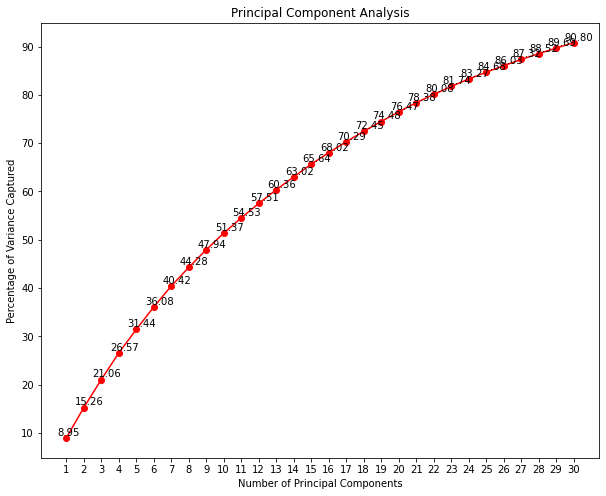

In [31]:
# This part of the code was referenced from the following source:
# https://m.blog.naver.com/PostView.nhn?blogId=tjdrud1323&logNo=221720259834&proxyReferer=https:%2F%2Fwww.google.com%2F

# 2-2. Choose number of principal components based on proportion of variance explained
test_pca(norm_matrix, n_components = 30)

In [32]:
# 2-3. conduct actual PCA
############## SET UP MANUALLY ##############
# no. of principal components
n_pc = 23
#############################################

pca_matrix = run_pca(norm_matrix, n_pc)

In [52]:
# 3-1. calculate variance inflation factor of independent vars to ensure no multicollinearity
test_vif(pca_matrix)

     Features  VIF Factor
0   Intercept         1.0
1    Q("pc1")         1.0
2    Q("pc2")         1.0
3    Q("pc3")         1.0
4    Q("pc4")         1.0
5    Q("pc5")         1.0
6    Q("pc6")         1.0
7    Q("pc7")         1.0
8    Q("pc8")         1.0
9    Q("pc9")         1.0
10  Q("pc10")         1.0
11  Q("pc11")         1.0
12  Q("pc12")         1.0
13  Q("pc13")         1.0
14  Q("pc14")         1.0
15  Q("pc15")         1.0
16  Q("pc16")         1.0
17  Q("pc17")         1.0
18  Q("pc18")         1.0
19  Q("pc19")         1.0
20  Q("pc20")         1.0
21  Q("pc21")         1.0
22  Q("pc22")         1.0
23  Q("pc23")         1.0


In [53]:
# 3-2. eliminate any additional variables that show multicollinearity
############## SET UP MANUALLY ##############
# sort out variables with VIF < 10 & one variable with VIF >= 10
x_vars = list(pca_matrix.columns[1:-1])
#############################################

x = pca_matrix[x_vars]

# 4. build basic independent & dependent variable sets
############## SET UP MANUALLY ##############
# number of training set data
num_train = 80
#############################################

num_data = len(x)
x_train, x_test = x[:num_train], x[num_train - num_data:]

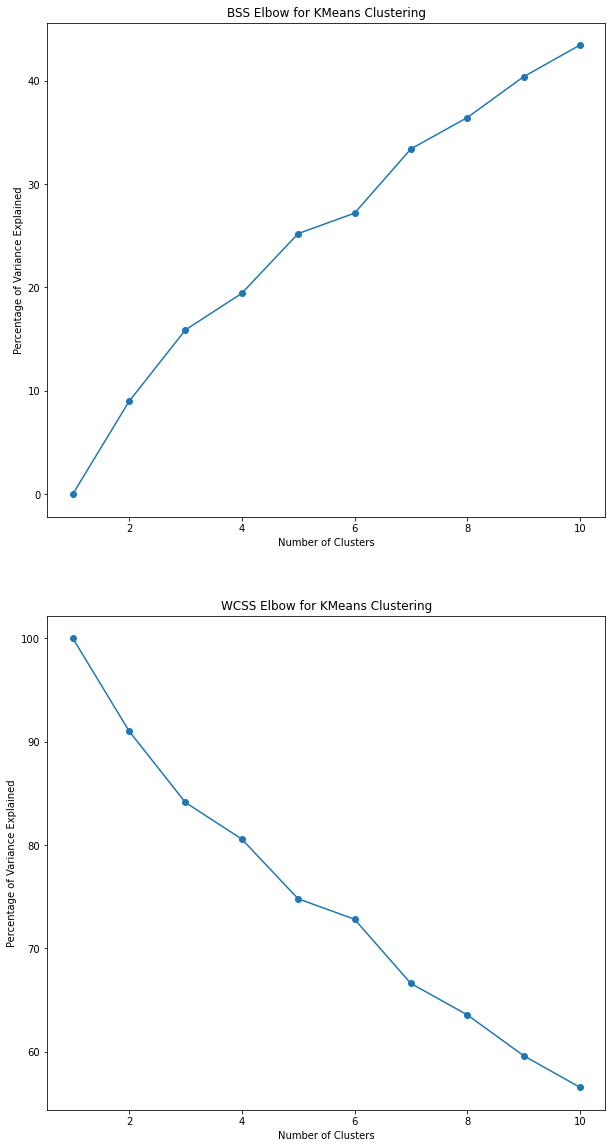

In [54]:
# ============== K-MEANS CLUSTERING ============== #
draw_kmeans(x_train)

In [55]:
############## SET UP MANUALLY ##############
# no. of clusters
n_clusters = 4
#############################################

# retrieve centroids based on training set
kmeans_train = KMeans(n_clusters = n_clusters).fit(x_train)
centroids = kmeans_train.cluster_centers_
x_train['KM'] = kmeans_train.labels_

# add labels for each cluster on testing set
kmeans_test = KMeans(n_clusters = n_clusters).fit(x_test)
x_test['KM'] = kmeans_test.labels_

# export data to external file in order to visually analyze cluster patterns
km = list(x_train.KM)
km.extend(list(x_test.KM))
matrix['KM'] = km
norm_matrix['KM'] = km
matrix.to_csv(f'kmeans_{n_clusters}.csv', encoding = 'utf-8')
norm_matrix.to_csv(f'kmeans_{n_clusters}_norm.csv', encoding = 'utf-8')

<ipython-input-55-876cac2f08d5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['KM'] = kmeans_train.labels_
<ipython-input-55-876cac2f08d5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['KM'] = kmeans_test.labels_


In [56]:
# ============== MODEL PREDICTION ============== #
# 1. grid search for best pair of (sigma, alpha)
############## SET UP MANUALLY ##############
# alpha (parameter) for regression
alphas = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
#############################################

# set up dependent variables
y = matrix[['target', 'KM']]
y_train, y_test = y[:num_train], y[num_train - num_data:]

# ML model test runs
grid_search_params(x_train, x_test, y_train, y_test, centroids, alphas, mrbf = False)

ML MODEL GRID SEARCH START!


c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6027639580956.329, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5913272990976.373, toler

           alpha = 10  alpha = 9  alpha = 8  alpha = 7  alpha = 6  alpha = 5  \
Cluster 1    0.978683   0.929232   0.873890   0.811756   0.741904   0.663610   
Cluster 2    1.018219   0.992343   0.963256   0.930393   0.893103   0.850702   
Cluster 3    1.352805   1.347222   1.339023   1.326799   1.308166   1.278883   
Cluster 4    1.183010   1.194442   1.209647   1.230688   1.261326   1.309063   

           alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717370       1.717821  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.

In [57]:
############## SET UP MANUALLY ##############
# sigma
sigs = list(range(100,2001,100))

# alpha (parameter) for regression
alphas = [5, 4, 3, 2, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
#############################################

# MRBF model test runs
grid_search_params(x_train, x_test, y_train, y_test, centroids, alphas, sigs, mrbf = True)

MRBF MODEL GRID SEARCH START!
[Sigma = 100]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571038542.069, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791429239.131, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663612   0.577020   0.485216   0.402014   0.399611     1.287664   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872702   
Cluster 3   1.278882   1.230929   1.147994   0.993991   0.686322     0.306600   
Cluster 4   1.309072   1.390823   1.552106   1.956344   3.647219    36.006846   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668132       1.710813        1.697535       1.570816  
Cluster 2      1.035968       1.061112        1.063913       1.070303  
Cluster 3      0.347513       0.355766        0.354911       0.342809  
Cluster 4     68.002897      73.340347       73.073945      67.107402  


[Sigma = 200]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571263714.793, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791654188.234, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485215   0.402012   0.399609     1.287677   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309064   1.390813   1.552095   1.956331   3.647201    36.007302   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668320       1.712736        1.716102       1.705420  
Cluster 2      1.035967       1.061105        1.063755       1.064093  
Cluster 3      0.347531       0.355956        0.356747       0.355738  
Cluster 4     68.011442      73.431289       73.955279      73.485651  


[Sigma = 300]



c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405165200887.232, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3776582677087.483, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error


           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309064   1.390813   1.552095   1.956330   3.647200    36.007326   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668330       1.712838        1.717120       1.715330  
Cluster 2      1.035967       1.061104        1.063752       1.064026  
Cluster 3      0.347531       0.355966        0.356847       0.356716  
Cluster 4     68.011892      73.436092       74.003498      73.955445  


[Sigma = 400]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571277640.721, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791668101.756, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309064   1.390813   1.552095   1.956330   3.647200    36.007330   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712855        1.717291       1.717031  
Cluster 2      1.035967       1.061104        1.063751       1.064020  
Cluster 3      0.347532       0.355968        0.356864       0.356885  
Cluster 4     68.011967      73.436898       74.011604      74.036086  


[Sigma = 500]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571278187.496, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791668648.091, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309064   1.390813   1.552094   1.956330   3.647200    36.007331   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712860        1.717337       1.717497  
Cluster 2      1.035967       1.061104        1.063751       1.064018  
Cluster 3      0.347532       0.355968        0.356869       0.356931  
Cluster 4     68.011988      73.437118       74.013818      74.058190  


[Sigma = 600]



c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791668844.229, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405165203506.136, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error


           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712861        1.717354       1.717665  
Cluster 2      1.035967       1.061104        1.063751       1.064018  
Cluster 3      0.347532       0.355968        0.356870       0.356947  
Cluster 4     68.011995      73.437196       74.014612      74.066135  


[Sigma = 700]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571278467.989, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791668928.304, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712862        1.717361       1.717737  
Cluster 2      1.035967       1.061104        1.063751       1.064018  
Cluster 3      0.347532       0.355968        0.356871       0.356955  
Cluster 4     68.011998      73.437230       74.014953      74.069542  


[Sigma = 800]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571278508.817, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791668969.101, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712862        1.717365       1.717772  
Cluster 2      1.035967       1.061104        1.063751       1.064018  
Cluster 3      0.347532       0.355968        0.356871       0.356958  
Cluster 4     68.012000      73.437247       74.015118      74.071195  


[Sigma = 900]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571278530.556, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791668990.8125, tole

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717367       1.717790  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356960  
Cluster 4     68.012001      73.437255       74.015206      74.072075  


[Sigma = 1000]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571278542.958, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669003.248, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717368       1.717801  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356961  
Cluster 4     68.012001      73.437260       74.015256      74.072578  


[Sigma = 1100]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571278550.486, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669010.717, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717368       1.717807  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356962  
Cluster 4     68.012001      73.437263       74.015287      74.072882  


[Sigma = 1200]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669015.459, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405165203669.631, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717369       1.717811  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356962  
Cluster 4     68.012001      73.437265       74.015306      74.073074  


[Sigma = 1300]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669018.598, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405165203672.614, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717369       1.717814  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356962  
Cluster 4     68.012002      73.437267       74.015319      74.073201  


[Sigma = 1400]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669020.72, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405165203674.649, tolera

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717369       1.717816  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356962  
Cluster 4     68.012002      73.437267       74.015327      74.073287  


[Sigma = 1500]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669022.23, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405165203676.055, tolera

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717369       1.717817  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356963  
Cluster 4     68.012002      73.437268       74.015333      74.073347  


[Sigma = 1600]



c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571278563.047, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669023.277, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error


           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717369       1.717818  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356963  
Cluster 4     68.012002      73.437268       74.015338      74.073390  


[Sigma = 1700]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669024.049, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405165203677.822, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717370       1.717819  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356963  
Cluster 4     68.012002      73.437269       74.015341      74.073422  


[Sigma = 1800]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669024.637, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405165203678.373, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717370       1.717819  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356963  
Cluster 4     68.012002      73.437269       74.015343      74.073445  


[Sigma = 1900]



c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571278564.862, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669025.08, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
 

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717370       1.717819  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356963  
Cluster 4     68.012002      73.437269       74.015345      74.073463  


[Sigma = 2000]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5166571278565.194, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4842791669025.406, toler

           alpha = 5  alpha = 4  alpha = 3  alpha = 2  alpha = 1  alpha = 0.1  \
Cluster 1   0.663610   0.577018   0.485214   0.402012   0.399609     1.287678   
Cluster 2   0.850702   0.802662   0.749295   0.694344   0.658767     0.872701   
Cluster 3   1.278883   1.230930   1.147995   0.993991   0.686323     0.306601   
Cluster 4   1.309063   1.390813   1.552094   1.956330   3.647200    36.007332   

           alpha = 0.01  alpha = 0.001  alpha = 0.0001  alpha = 1e-05  
Cluster 1      1.668332       1.712863        1.717370       1.717820  
Cluster 2      1.035967       1.061104        1.063751       1.064017  
Cluster 3      0.347532       0.355968        0.356872       0.356963  
Cluster 4     68.012002      73.437269       74.015346      74.073477  


MRBF MODEL GRID SEARCH COMPLETE!


In [58]:
# 2. report final result with best parameters
############## SET UP MANUALLY ##############
# final parameters
alpha = 2
sig = 300
#############################################

best_models(x_train, x_test, y_train, y_test, centroids, alpha, sig)

*******************BEST RESULTS*******************
[Settings]
 ML: alpha = 2
 MRBF: alpha = 2, sigma = 300

ML Model Coefficients:
[ 4.98915842e+04  2.70296250e+04 -1.26905913e+04 -2.25894148e+04
  7.40717990e+01  9.89288485e+03 -3.39275201e+04 -4.11688899e+04
  6.59415672e+03  8.80551765e+04 -2.74805664e+03 -2.51352950e+04
 -1.11399149e+04 -3.30926465e+04 -4.36163886e+03  3.84916921e+04
  6.29721053e+03  8.58963487e+03  1.96103773e+04 -3.85676711e+03
 -1.84466930e+04  1.57234720e+04 -1.05314088e+04]

MRBF Model Coefficients:
[ 4.98915841e+04  2.70296247e+04 -1.26905913e+04 -2.25894145e+04
  7.40718402e+01  9.89288458e+03 -3.39275202e+04 -4.11688900e+04
  6.59415660e+03  8.80551765e+04 -2.74805667e+03 -2.51352950e+04
 -1.11399149e+04 -3.30926466e+04 -4.36163884e+03  3.84916918e+04
  6.29721059e+03  8.58963496e+03  1.96103770e+04 -3.85676708e+03
 -1.84466931e+04  1.57234719e+04 -1.05314089e+04  3.79845034e+00
  1.63672530e+00  3.25189988e+00  1.37455331e+00]



c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3776582679453.1953, tolerance: 1482759875.0
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass l1_ratio=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3776582677087.483, tole

           ML Model  MRBF Model
Cluster 1  0.402012    0.402012
Cluster 2  0.694344    0.694344
Cluster 3  0.993991    0.993991
Cluster 4  1.956330    1.956330
